# Apuntes

In [6]:
# Librerías
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [1]:
!jt -t chesterish -T -N -kl

# Datos

## Lectura

Fechas train : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Fechas test  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


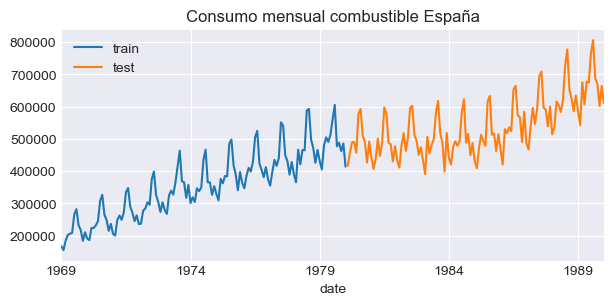

In [8]:
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/consumos-combustibles-mensual.csv')
datos = pd.read_csv(url, sep=',')
datos = datos[['Fecha', 'Gasolinas']]
datos = datos.rename(columns={'Fecha':'date', 'Gasolinas':'litters'})
datos['date'] = pd.to_datetime(datos['date'], format='%Y-%m-%d')
datos = datos.set_index('date')
datos = datos.loc[:'1990-01-01 00:00:00']
datos = datos.asfreq('MS')
datos = datos['litters']
# Train-test
fin_train = '1980-01-01 23:59:59'
print(f"Fechas train : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  (n={len(datos.loc[:fin_train])})")
print(f"Fechas test  : {datos.loc[fin_train:].index.min()} --- {datos.loc[:].index.max()}  (n={len(datos.loc[fin_train:])})")
datos_train = datos.loc[:fin_train]
datos_test  = datos.loc[fin_train:]
# Gráfico
fig, ax=plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.set_title('Consumo mensual combustible España')
ax.legend();

## Test estacionariedad

Estacionariedad: la estacionariedad significa que las propiedades estadísticas (media, varianza...) permanecen constantes a lo largo del tiempo, por lo que las series temporales con tendencias o estacionalidad no son estacionarias. Dado que ARIMA presupone la estacionariedad de los datos, es esencial someterlos a pruebas rigurosas, como la prueba Dickey-Fuller aumentada, para evaluar que se cumple. Si se constata la no estacionariedad, las series deben diferenciarse hasta alcanzar la estacionariedad. Este análisis ayuda a determinar el valor óptimo del parámetro  d

Análisis de autocorrelación: Graficar las funciones de autocorrelación y autocorrelación parcial (ACF y PACF) para identificar posibles relaciones de rezago (lags) entre los valores de la serie. Este análisis visual ayuda a determinar los términos autorregresivos (AR) y de media móvil (MA) adecuados ( p
  y  q
 ) para el modelo ARIMA.

In [9]:
datos_diff_1 = datos_train.diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

La prueba Dickey-Fuller aumentada considera como hipótesis nula que la serie temporal tiene una raíz unitaria, una característica frecuente de las series temporales no estacionarias. Por el contrario, la hipótesis alternativa (bajo la cual se rechaza la hipótesis nula) es que la serie es estacionaria.
- Hipótesis nula ( HO ): La serie tiene una raíz unitaria, no es estacionaria.
- Hipótesis alternativa ( HA ): La serie no tiene raíz unitaria, es estacionaria. 

La prueba KPSS comprueba si una serie temporal es estacionaria en torno a una media o una tendencia lineal. En esta prueba, la hipótesis nula es que la serie es estacionaria. Por consiguiente, los p-values pequeños (por ejemplo, inferiores a 0.05) rechazan la hipótesis nula y sugieren que es necesario diferenciar.

Test estacionariedad serie original
ADF Statistic: -0.4461298099822748, p-value: 0.9021071923942674
KPSS Statistic: 2.2096370946978388, p-value: 0.01


<Axes: title={'center': 'Serie original'}, xlabel='date'>

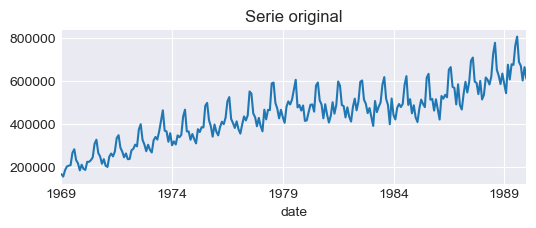

In [24]:
print('Test estacionariedad serie original')
adfuller_result = adfuller(datos)
kpss_result = kpss(datos)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

fig, axs = plt.subplots(figsize=(6, 2), sharex=True)
datos.plot(title='Serie original')


Test estacionariedad para serie diferenciada (order=1)
ADF Statistic: -3.6417276900323077, p-value: 0.005011605002137493
KPSS Statistic: 0.31327116235727637, p-value: 0.1


<Axes: title={'center': 'Diferenciación orden 1'}, xlabel='date'>

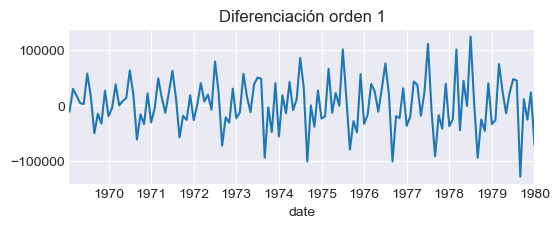

In [25]:
print('\nTest estacionariedad para serie diferenciada (order=1)')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
fig, axs = plt.subplots(figsize=(6, 2), sharex=True)
datos_diff_1.plot(title='Diferenciación orden 1')


Test estacionariedad para serie diferenciada (order=2)
ADF Statistic: -8.233942641655922, p-value: 5.959599575498902e-13
KPSS Statistic: 0.08065668267482097, p-value: 0.1


<Axes: title={'center': 'Diferenciación orden 2'}, xlabel='date'>

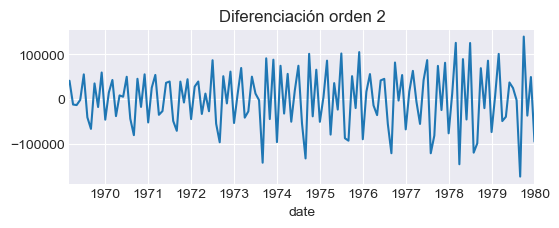

In [26]:
print('\nTest estacionariedad para serie diferenciada (order=2)')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
fig, axs = plt.subplots(figsize=(6, 2), sharex=True)
datos_diff_2.plot(title='Diferenciación orden 2')

## Análisis de autocorrelación

El gráfico de la función de autocorrelación ( Autocorrelation Function ACF) y la función de autocorrelación parcial (Partial Autocorrelation Function (PACF)) de la serie temporal proporciona información útil sobre los posibles valores adecuados de  p
  y  q
 . La ACF ayuda a identificar el valor de  q
  (retardos en la parte de media móvil), mientras que la PACF ayuda a identificar el valor de  p
  (retardos en la parte autorregresiva).

Text(0.5, 1.0, 'Autocorrelación serie diferenciada (order=1)')

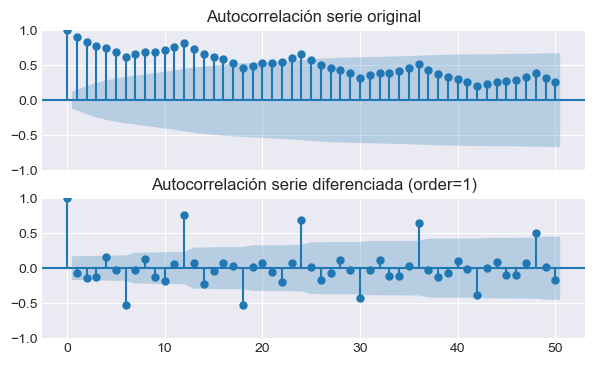

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)')

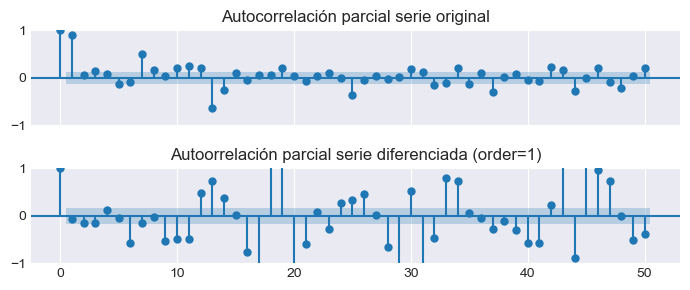

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout()

Acorde a la función de autocorrelación, el valor óptimo para el parámetro  p
  es 0. Sin embargo, se va a asignar un valor de 1 para proporcionar un componente autorregresivo al modelo. En cuanto al componente  q
 , la función de autocorrelación parcial sugiere un valor de 1.

## Descomposición 

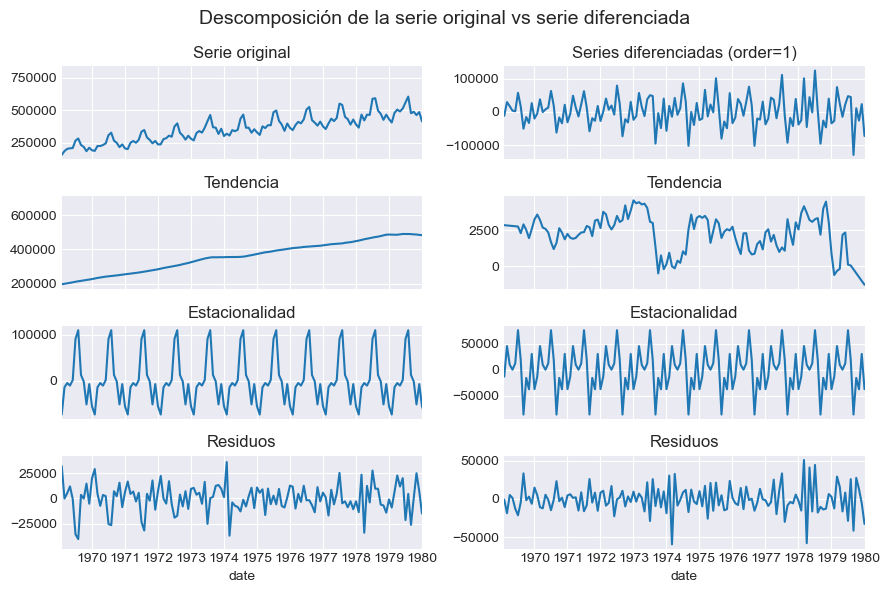

In [37]:
res_decompose = seasonal_decompose(datos, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(datos_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original')
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos')
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)')
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia')
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad')
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos')
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout()

El patrón recurrente cada 12 meses sugiere una estacionalidad anual, probablemente influenciada por factores vacacionales. El gráfico de ACF respalda aún más la presencia de esta estacionalidad, ya que se observan picos significativos en los lags correspondientes a los intervalos de 12 meses, confirmando la idea de patrones recurrentes.

## Conclusiones

Basandose en los resultados del análisis exploratorio, utilizar una combinación de diferenciación de primer orden y diferenciación estacional puede ser el enfoque más apropiado. La diferenciación de primer orden es efectiva para capturar las transiciones entre observaciones y resaltar las fluctuaciones a corto plazo. Al mismo tiempo, la diferenciación estacional, que abarca un período de 12 meses y representa el cambio de un año a otro, captura de manera efectiva los patrones cíclicos inherentes en los datos. Este enfoque nos permite lograr la estacionariedad necesaria para el proceso de modelado ARIMA subsiguiente.

In [39]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional

datos_diff_1_12 = datos_train.diff().diff(12).dropna()

adfuller_result = adfuller(datos_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')


ADF Statistic: -4.387457230769946, p-value: 0.0003123773271127068
KPSS Statistic: 0.06291573421251051, p-value: 0.1


# Modelo ARIMA-SARIMAX

El resumen del modelo muestra mucha información sobre el proceso de ajuste:

Estadísticas de Ajuste del Modelo: Esta parte incluye varias estadísticas que ayudan a evaluar qué tan bien el modelo se ajusta a los datos observados:

Log-Likelihood (Logaritmo de la Verosimilitud): Una medida de qué tan bien el modelo explica los datos observados, donde valores más negativos indican un ajuste deficiente a los datos y valores más cercanos a cero indican un mejor ajuste.

AIC (Criterio de Información de Akaike): Una métrica de bondad de ajuste que equilibra el ajuste del modelo con su complejidad. Cuanto menor el valor de AIC mejor es el modelo.

BIC (Criterio de Información Bayesiano): Similar al AIC, pero penaliza más la complejidad del modelo. Al igual que con el AIC, valores más bajos de BIC indican un mejor ajuste.

HQIC (Criterio de Información de Hannan-Quinn): Otro criterio de selección de modelo, similar al AIC y al BIC.

Coeficientes: Esta tabla lista los coeficientes estimados para los parámetros del modelo. Incluye tanto los parámetros autoregresivos (AR) como los parámetros de media móvil (MA), así como cualquier variable exógena si se incluyen en el modelo. También incluye los errores estándar asociados con los coeficientes estimados para indicar la incertidumbre de dichas estimaciones, sus p-values, que se utilizan para evaluar la significancia de cada coeficiente, y el intervalo de confianza del 95%.

Diagnósticos del modelo: Esta sección proporciona información sobre los residuos. Las diferencias entre los valores observados (valores de entrenamiento) y los valores predichos por el modelo.

Prueba Ljung-Box: Una prueba de autocorrelación en los residuos.

Prueba de Jarque-Bera: Una prueba de normalidad de los residuos.

Asimetría y curtosis: Medidas de la forma de la distribución de los residuos.

## Con statsmodels.Sarimax

In [40]:
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = datos_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            litters   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1356.051
Date:                            Thu, 28 Mar 2024   AIC                           2722.103
Time:                                    10:08:04   BIC                           2736.040
Sample:                                01-01-1969   HQIC                          2727.763
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4972      0.134     -3.707      0.000      -0.760      -0.234
ma.L1         -0.0096      0.146     -0.066      0.947      -0.295       0.276
ar.S.L12       0.0465      0.162      0.288      0.774      -0.270       0.364
ma.S.L12      -0.3740      0.203     -1.847      0.065      -0.771       0.023
sigma2      3.291e+08   1.06e-09    3.1e+17      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   5.13   Jarque-Bera (JB):                18.12
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.42
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.62e+32. Standard errors may be unstable.
"""

In [42]:
predicciones_statsmodels = modelo_res.get_forecast(steps=len(datos_test)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

1980-02-01    407504.056940
1980-03-01    473997.245813
1980-04-01    489983.091501
1980-05-01    485517.462869
Freq: MS, Name: predicciones_statsmodels, dtype: float64

## Skforecast

In [43]:
modelo = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            litters   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1356.051
Date:                            Thu, 28 Mar 2024   AIC                           2722.103
Time:                                    11:06:20   BIC                           2736.040
Sample:                                01-01-1969   HQIC                          2727.763
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4972      0.134     -3.707      0.000      -0.760      -0.234
ma.L1         -0.0096      0.146     -0.066      0.947      -0.295       0.276
ar.S.L12       0.0465      0.162      0.288      0.774      -0.270       0.364
ma.S.L12      -0.3740      0.203     -1.847      0.065      -0.771       0.023
sigma2      3.291e+08   1.06e-09    3.1e+17      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   5.13   Jarque-Bera (JB):                18.12
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.42
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.62e+32. Standard errors may be unstable.
"""

In [44]:
predicciones_skforecast = modelo.predict(steps=len(datos_test))
display(predicciones_skforecast.head(4))

,pred
1980-02-01,407504.056940
1980-03-01,473997.245813
1980-04-01,489983.091501
1980-05-01,485517.462869


## pdmarima

In [45]:
modelo = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1355.749
Date:                            Thu, 28 Mar 2024   AIC                           2723.498
Time:                                    11:08:13   BIC                           2740.223
Sample:                                01-01-1969   HQIC                          2730.290
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -474.5820   1101.722     -0.431      0.667   -2633.917    1684.753
ar.L1         -0.4896      0.138     -3.554      0.000      -0.760      -0.220
ma.L1         -0.0211      0.151     -0.139      0.889      -0.317       0.275
ar.S.L12       0.0545      0.164      0.331      0.740      -0.268       0.377
ma.S.L12      -0.3841      0.204     -1.884      0.060      -0.784       0.015
sigma2      3.289e+08      0.002   1.84e+11      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   4.90   Jarque-Bera (JB):                18.55
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.43
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.51e+27. Standard errors may be unstable.
"""

In [46]:
predicciones_pdmarima = modelo.predict(len(datos_test))
predicciones_pdmarima.name = 'predicciones_pdmarima'
display(predicciones_pdmarima.head(4))

1980-02-01    406998.311386
1980-03-01    472944.444457
1980-04-01    488389.125308
1980-05-01    483432.075675
Freq: MS, Name: predicciones_pdmarima, dtype: float64

C:\Users\Usuario\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


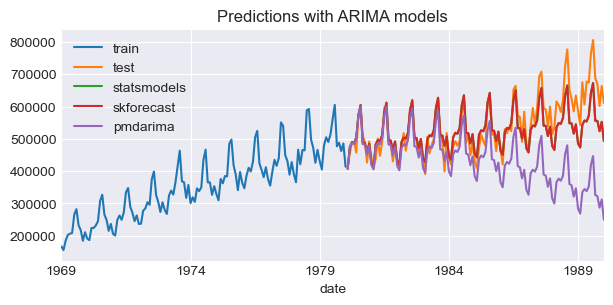

In [53]:
fig, ax = plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_statsmodels.plot(ax=ax, label='statsmodels')
predicciones_skforecast.columns = ['skforecast']
predicciones_skforecast.plot(ax=ax, label='skforecast')
predicciones_pdmarima.plot(ax=ax, label='pmdarima')
ax.set_title('Predictions with ARIMA models')
ax.legend()

## ForecasterSarimax

In [48]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=datos_train, suppress_warnings=True)

In [49]:
predicciones = forecaster.predict(steps=len(datos_test))
predicciones.head(4)

1980-02-01    407504.056940
1980-03-01    473997.245813
1980-04-01    489983.091501
1980-05-01    485517.462869
Freq: MS, Name: pred, dtype: float64

## Backtesting

Aquí se crea un objeto ForecasterSarimax, que es un modelo SARIMA, con los siguientes parámetros:

order=(1, 1, 1): Parámetros (p, d, q) del componente autoregresivo, diferenciación y componente de media móvil, respectivamente.
seasonal_order=(1, 1, 1, 12): Parámetros (P, D, Q, S) del componente autoregresivo, diferenciación, componente de media móvil y período de estacionalidad, respectivamente.
maxiter=200: Número máximo de iteraciones permitidas en la optimización.

In [60]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=200))

    -forecaster: El modelo SARIMA definido anteriormente.
    -y: La serie temporal de datos.
    -initial_train_size: Tamaño del conjunto de entrenamiento inicial.
    -fixed_train_size: Si se mantiene fijo el tamaño del conjunto de entrenamiento.
    -steps: Número de pasos a predecir hacia adelante.
    -metric: Métrica utilizada para evaluar el rendimiento del modelo (en este caso, el error absoluto medio).
    -refit: Si se debe ajustar el modelo con los datos completos después de realizar las predicciones.
    -n_jobs: Número de trabajos en paralelo (auto indica que se utiliza el número de CPU disponibles).
    -suppress_warnings_fit: Si se deben suprimir las advertencias durante el ajuste del modelo.
    -verbose: Si se muestra información detallada durante el proceso.
    -show_progress: Si se muestra el progreso del proceso.

In [ ]:
metrica, predicciones = backtesting_sarimax(
                            forecaster            = forecaster,
                            y                     = datos,
                            initial_train_size    = len(datos_train),
                            fixed_train_size      = False,
                            steps                 = 12,
                            metric                = 'mean_absolute_error',
                            refit                 = True,
                            n_jobs                = "auto",
                            suppress_warnings_fit = True,
                            verbose               = True,
                            show_progress         = True)

In [58]:
print(f"Metrica (mean absolute error): {metrica}")
display(predicciones.head(4))

Information of backtesting process
----------------------------------
Number of observations used for initial training: 133
Number of observations used for backtesting: 120
    Number of folds: 10
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1980-01-01 00:00:00  (n=133)
    Validation: 1980-02-01 00:00:00 -- 1981-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1981-01-01 00:00:00  (n=145)
    Validation: 1981-02-01 00:00:00 -- 1982-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1982-01-01 00:00:00  (n=157)
    Validation: 1982-02-01 00:00:00 -- 1983-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=169)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=181)
    Validation: 1984-02-01 00:00:00 --

  0%|          | 0/10 [00:00<?, ?it/s]

Metrica (mean absolute error): 19611.236351426574


,pred
1980-02-01,407504.056940
1980-03-01,473997.245813
1980-04-01,489983.091501
1980-05-01,485517.462869


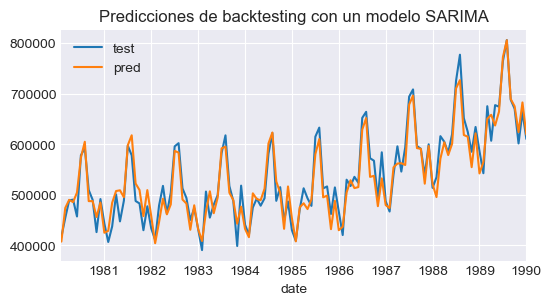

In [59]:
fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_train:].plot(ax=ax, label='test')
predicciones.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend()